# imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.preprocessing
import random

In [3]:
np.random.seed(0)

# import data

In [5]:
"""
x: weather data (3xN) (april 1st until now)
[[percip1, percip2, percip3, percip4],
 [temp1,   temp2,   ...]
 [bias1,   bias2,   ...]]

y: mbta delays  (1xN) (april 1st until now)
[[delay1,  delay2,  ...]]
includes non-delays.
""";

In [6]:
# read csv and keep certain cols
spt = pd.read_csv(r"C:\Users\Overl\DS4420\assets\HW4\ds4420_spotify.csv")
spt = spt[["release_month","release_year","artist_pop","track_pop","duration_s","explicit"]]

In [7]:
def df_scaler(df,cols):
    df = df.copy(deep=True)
    scaler = sklearn.preprocessing.StandardScaler()
    df.loc[:,cols] = scaler.fit_transform(df[cols])
    return df

In [8]:
spt = df_scaler(spt,cols = ["release_month",
                            "release_year",
                            "artist_pop",
                            "duration_s"])

In [9]:
# explicitly define x
x = spt[["release_month","release_year","artist_pop","duration_s","explicit"]]

# add bias column to x
x["bias"] = np.ones(x.shape[0])

# convert x to numpy
x = x.to_numpy()

In [10]:
# explicitly define y
y = spt["track_pop"].to_numpy()

# pointers
(set pointers for x_train, x_test, y_train, y_test)

In [12]:
def tt_idx(y,train_percent:float):
    y_len = len(y)
    # get random non-repeating 
    # values for unique indicies:
    train_idx = random.sample(range(y_len),
                              int(y_len*train_percent))
    
    # store train vs test in dict
    tt_idx_dict = {
        "train":list(filter(lambda x: 
                            x in train_idx,
                            range(y_len))),
        "test": list(filter(lambda x: 
                            x not in train_idx,
                            range(y_len)))
    }
    
    # return dict
    return tt_idx_dict

In [54]:
tt_dict = tt_idx(y,0.7)
train_idx = tt_dict["train"]
test_idx  = tt_dict["test"]

In [14]:
x_train = x[train_idx]
y_train = y[train_idx]
x_test  = x[test_idx]
y_test  = y[test_idx]

# define MLP

In [16]:
class AbstractAF:
    """Abstract Activation Function.
    This is an abstract class used to represent
    activation functions in a MultiLayer Perceptitron.

    Each Activation function must have a name
    and implement the following three functions:
    - fw(w,x)         represents a forward pass through the MLP
    - bp_w(w,x)       represents a dL/dw backprop through the MLP
    - bp_x(w,x)       represents a dL/dh backprop through the MLP <- TODO look into this.....

    This class does not implement any of the three functions.
    Child-classes MUST implement all three functions for 
    backprop to work properly.

    In the current implementation, the following classes are the only valid subclasses:
    - LinearAF
    - ReluAF
    """
    def __init__(self):
        self.name = "Abstract"

    def __repr__(self):
        """Overwrites the representation with class name.
        This function makes the print look cleaner :) 
        """
        return f"<ActivationFunction:{self.name}>"
    
    def fw(self,w,x):
        raise NotImplementedError("Abstract Class cannot run functions.  Please use a subclass.")

    def bp_w(self,w,x):
        raise NotImplementedError("Abstract Class cannot run functions.  Please use a subclass.")

    def bp_x(self,w,x):
        raise NotImplementedError("Abstract Class cannot run functions.  Please use a subclass.")

class MeanSquaredErrorAF(AbstractAF):
    """Mean Squared Error function"""
    def __init__(self):
        super().__init__()
        self.name = "MSE"
        self.axis = 0

    def fw(self,f,y):
        return   np.mean((f-y)**2,axis=1).item()

    def bp(self,f,y):
        return 2*np.mean((f-y),   axis=self.axis)

class LinearAF(AbstractAF):
    """Linear Activation Function"""
    def __init__(self):
        super().__init__()
        self.name = "Linear"
    
    def fw(self,w,x):
        return w.T.dot(x)

    def bp_w(self,w,x):
        return x

    def bp_x(self,w,x):
        return w

class ReluAF(AbstractAF):
    """Relu Activation Function"""
    def __init__(self):
        super().__init__()
        self.name = "Relu"
        
    def fw(self,w,x):
        return np.maximum(0,w.T.dot(x))

    def bp_w(self,w,x):
        print("wtx:",(w.T.dot(x) > 0).shape)
        print("x:",x.shape,"(expected)")
        return x.dot((w.T.dot(x) > 0).T)

    def bp_x(self,w,x):
        print("wtx:",(w.T.dot(x) > 0).shape)
        print("w:",w.shape,"(expected)")
        return (w).dot(w.T.dot(x) > 0)

In [17]:
class MLP:
    """MultiLayer Perceptron
    Implementation Notes:
    - input and output layers must be defined explicitly.
    """
    def __init__(self):
        self.layers  = []
        self.weights = []
        self.loss = MeanSquaredErrorAF()

    def add_layer(self,nodes:int,afunc:AbstractAF) -> None:
        """Adds a layer with a given number of nodes
        and a given Abstract Function"""
        self.layers.append(MLPLayer(nodes,afunc))

    def _init_weights(self) -> None:
        """Initialize weights based on added layers"""
        assert len(self.layers) > 1, "layers must be added"

        # reset weights matrix
        self.weights = []

        # get the shape based on existing layers
        for i in range(1,len(self.layers)):
            w_shape = (self.layers[i-1].get_nodes(),
                       self.layers[i  ].get_nodes())
            self.weights.append(np.ones(w_shape)*0.01)

    def fw(self,x:np.array):
        """Performs a forward pass from
        x through n hidden layers to f_w(x)
        by applying an activation function 
        for each layer in the MLP.

        The function also initializes weight
        dimensions, if not done so already.

        Given the input example:
        x_ample = np.ones((3,n))
        
        each column would represent a sample
        ie: 
        > x_ample[:,0]   would be the 1st sample
        > x_ample[:,1]   would be the 2nd sample
        > x_ample[:,n-1] would be the nth sample
        etc.
        
        each row would represent a variable
        ie:
        > x_ample[0,:] would be the 1st parameter
        > x_ample[1,:] would be the 2nd parameter
        > x_ample[2,:] would be the 3rd parameter
        etc.

        The output of this function will generally take the shape:
        (m,n) where n is the number of columns in the input array
        and m is the number of node is the final layer in this MLP.
        In this case, we are predicting one value, how late the
        MBTA will be, and therefore m will always be 1.
        """

        # init weights if not yet done
        if len(self.weights) == 0:
            self._init_weights()

        # initialize x as the hidden value
        # of layer 0 (the input layer)
        self.layers[0].h = x

        # loop through and update x iteratively:
        for i in range(1,len(self.layers)):
            x = self.layers[i].fw(self.weights[i-1],x)

        # return x
        return x
    
    def _bp_list_factors(self,ridx,debug:bool=False):
        """Gets a list of factors to
        generate the corresponding
        weight matrix.
        
        ridx is the reversed index:
        - 0 refers to the last element
        - 1 refers to the 2nd to last element
        etc.
        """
        reversed_weights = list(reversed(self.weights))
        reversed_layers  = list(reversed(self.layers))

        # store factors to prod later 
        prod_factors = []

        # loop through the layers add dh
        for i in range(ridx):
            if debug:
                print(f"""iteration:[{i}]:\n
                layer.h: {reversed_layers[i+1].h.shape}\n
                weight : {reversed_weights[i].shape}\n
                dotable: {...}\n
                """)
            
            # print(f"{reversed_layers[i+1]}.bp_x(...); shape:{reversed_weights[i].shape}")
            prod_factors.append(reversed_layers[i+1].bp_x(reversed_weights[i]))

        # add dw
        # print(f"{reversed_layers[ridx+1]}.bp_w(...); shape:{reversed_weights[ridx].shape}")
        prod_factors.append(reversed_layers[ridx+1].bp_w(reversed_weights[ridx]))

        # return factors
        return prod_factors

    def _bp_dot(self,bp_list,loss,debug:bool=False):
        """bp_list is the list generated from _bp_list_factors()
        loss is the VALUES of loss as a matrix
        """
        prod_dh = loss.copy()
    
        # ignore the last value b/c it's dw not dh
        for i in range(len(bp_list) - 1):
            # perform a cumulative dot product
            # starting from back:
            if debug:
                print(f"""iteration:[{i}]:\n
                bp_list: {bp_list[i].shape}\n
                prod_dh: {prod_dh.shape}\n
                dotable: {bp_list[i][1]==prod_dh.shape[0]}\n
                """)
                
            try:
                prod_dh = bp_list[i].dot(prod_dh)
            except:
                prod_dh = bp_list[i] * (prod_dh)
            
    
        # dot dw with the prod_dh transpose
        dldw = bp_list[-1].dot(prod_dh.T)
        return dldw
    
    def gd(self,
           x:np.array,
           y:np.array,
           eta:float=0.1,
           iters:int=10,
           debug:bool=False
          ):
        # list of errors?
        ls_mse = []
        
        for i in range(iters):
            # compute the fwd pass
            fwp = self.fw(x)
            # compute the loss
            fwl = self.loss.fw(f=fwp,y=y)
            bpl = self.loss.bp(f=fwp,y=y).reshape(1,-1)
            for fidx in range(len(self.weights)):
                ridx = len(self.weights) - fidx - 1
                bpd = self._bp_dot(self._bp_list_factors(fidx),bpl,debug=debug)
                    
                if debug:
                    print(f"shape match: {self.weights[ridx].shape == bpd.shape}")
                    print(f"    self.weights[{ridx}]",self.weights[ridx].shape)
                    print(f"    self._bp_dot[{ridx}]",bpd.shape)

                if bpd.shape == self.weights[ridx].shape:
                    # overwrite the weights if the shapes match:
                    self.weights[ridx] = (self.weights[ridx] - eta * bpd)
                else:
                    # throw error otherwise
                    raise Exception("invalid weight shape"+
                                    f"expected{self.weights[ridx].shape}; got{bpd.shape}")
            
            ls_mse.append(fwl)
        return ls_mse

In [18]:
class MLPLayer:
    """Represents a single layer in the MLP.
    
    """
    def __init__(self,nodes,afunc):
        self.nodes = int(nodes)
        self.afunc = afunc
        self.h = None

    def __repr__(self):
        """overwrite representation for pretty print"""
        return "<MLPLayer: {nodes:"+f"{self.nodes},afunc:{self.afunc}"+"}>"

    def get_nodes(self):
        return self.nodes+0

    def fw(self,w:np.array,x:np.array):
        """store and return the
        post-activation values 
        of a forward pass."""
        self.h = self.afunc.fw(w=w,x=x)
        return self.h.copy()

    def bp_w(self,w:np.array):
        return self.afunc.bp_w(w=w,x=self.h)

    def bp_x(self,w:np.array):
        return self.afunc.bp_x(w=w,x=self.h)

In [86]:
mlp = MLP()
mlp.add_layer(6,LinearAF()) # input x
mlp.add_layer(10,LinearAF())
mlp.add_layer(20,LinearAF())
mlp.add_layer(1,ReluAF()) # prediction f_w(x)

# run 1000 iters of gradient descent
err = mlp.gd(x_train.T,
             y_train.T,
             eta=0.00001,
             iters=10_000)

In [87]:
mlp.weights

[array([[0.029662827903849213, 0.029662827903849213, 0.029662827903849213,
         0.029662827903849213, 0.029662827903849213, 0.029662827903849213,
         0.029662827903849213, 0.029662827903849213, 0.029662827903849213,
         0.029662827903849213],
        [-0.02644126251526461, -0.02644126251526461, -0.02644126251526461,
         -0.02644126251526461, -0.02644126251526461, -0.02644126251526461,
         -0.02644126251526461, -0.02644126251526461, -0.02644126251526461,
         -0.02644126251526461],
        [0.3148760002969946, 0.3148760002969946, 0.3148760002969946,
         0.3148760002969946, 0.3148760002969946, 0.3148760002969946,
         0.3148760002969946, 0.3148760002969946, 0.3148760002969946,
         0.3148760002969946],
        [-0.004896011877386425, -0.004896011877386425,
         -0.004896011877386425, -0.004896011877386425,
         -0.004896011877386425, -0.004896011877386425,
         -0.004896011877386425, -0.004896011877386425,
         -0.00489601187738642

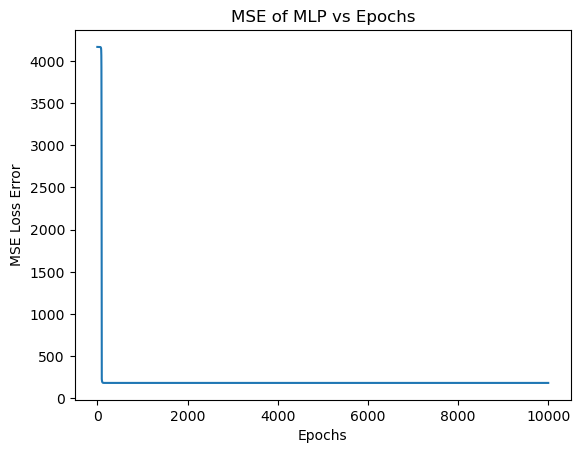

In [88]:
# plot the change in error over iterations
plt.plot(err)
plt.title("MSE of MLP vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss Error")
plt.show()

In [89]:
y_pred = mlp.fw(x_train.T).astype(int)

In [90]:
np.corrcoef(y_pred.flatten(),y_train.flatten())

array([[1.        , 0.71223542],
       [0.71223542, 1.        ]])

(-40.0, 100.0)

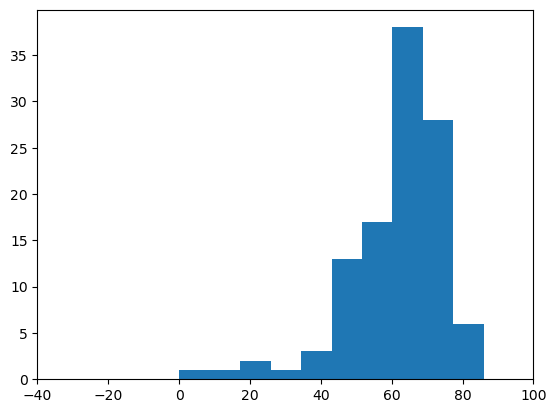

In [91]:
plt.hist(y_pred.astype(int).flatten())
plt.xlim(-40,100)

(-40.0, 100.0)

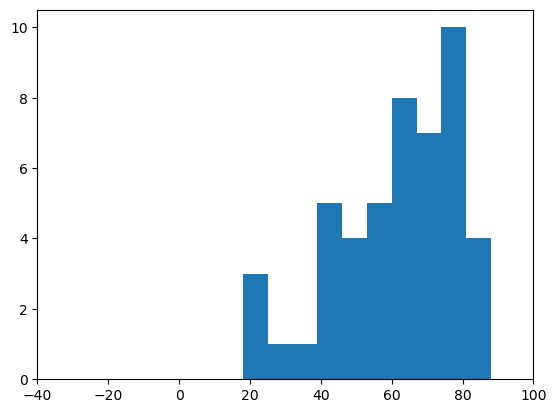

In [92]:
plt.hist(y_test.astype(int).flatten())
plt.xlim(-40,100)